# A Quick Guide to Deep Learning with Python

Kai Zhang, Duke Kunshan University, 2022

# Lecture x Restricted Boltzmann Machine (RBM)


**References:**


[Hinton2002] Training Products of Experts by Minimizing
Contrastive Divergence https://dl.acm.org/doi/10.1162/089976602760128018



[Hinton2006] Reducing the Dimensionality of
Data with Neural Networks https://doi.org/10.1126/science.1127647

[Lisa2008] Deep Learning Tutorial  https://github.com/lisa-lab/DeepLearningTutorials/blob/master/code/rbm.py


[Hinton2012] A Practical Guide to Training Restricted
Boltzmann Machines https://link.springer.com/chapter/10.1007/978-3-642-35289-8_32


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import text

import matplotlib
import math
import os

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

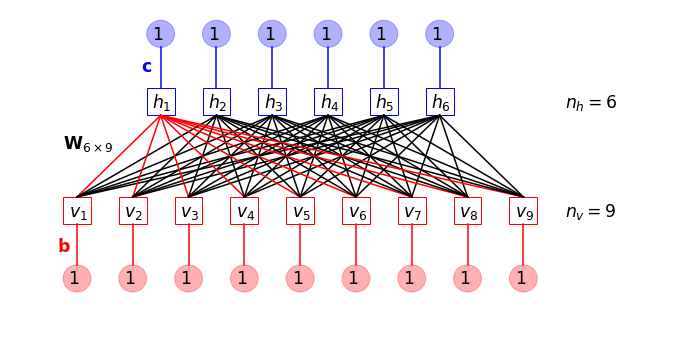

In [5]:
fig, ax = plt.subplots(figsize=(12,6))

for i in range(9):
  rectangle = plt.Rectangle((0.5*i + 0.5,1), 0.25, 0.25, fc='none',ec="red")
  ax.add_patch(rectangle)

for i in range(6):
  rectangle = plt.Rectangle((0.5*i + 1.25,2), 0.25, 0.25, fc='none',ec="blue")
  ax.add_patch(rectangle)

for i in range(9):
  for j in range(6):
    if j==0:
      plt.plot([0.5*i+0.625, 0.5*j+1.375],[1.25,2], 'r-')
    else:
      plt.plot([0.5*i+0.625, 0.5*j+1.375],[1.25,2], 'k-')
  
text(0.5+0.05,1.07,'$v_1$',size='xx-large')
text(1.0+0.05,1.07,'$v_2$',size='xx-large')
text(1.5+0.05,1.07,'$v_3$',size='xx-large')
text(2.0+0.05,1.07,'$v_4$',size='xx-large')
text(2.5+0.05,1.07,'$v_5$',size='xx-large')
text(3.0+0.05,1.07,'$v_6$',size='xx-large')
text(3.5+0.05,1.07,'$v_7$',size='xx-large')
text(4.0+0.05,1.07,'$v_8$',size='xx-large')
text(4.5+0.05,1.07,'$v_9$',size='xx-large')

text(1.0+0.3,2.07,'$h_1$',size='xx-large')
text(1.5+0.3,2.07,'$h_2$',size='xx-large')
text(2.0+0.3,2.07,'$h_3$',size='xx-large')
text(2.5+0.3,2.07,'$h_4$',size='xx-large')
text(3.0+0.3,2.07,'$h_5$',size='xx-large')
text(3.5+0.3,2.07,'$h_6$',size='xx-large')

for i in range(9):
  circle = plt.Circle((0.5*i + 0.625,0.5), 0.125, edgecolor='r', facecolor = 'red', alpha=0.3)
  ax.add_patch(circle)
  text(0.5*i + 0.55,0.45,'1',size='xx-large')
  plt.plot([0.5*i+0.625, 0.5*i+0.625],[0.625,1], 'r-')

for i in range(6):
  circle = plt.Circle((0.5*i + 1.375,2.75), 0.125, edgecolor='b', facecolor = 'blue', alpha=0.3)
  ax.add_patch(circle)
  text(0.5*i + 1.3,2.7,'1',size='xx-large')
  plt.plot([0.5*i+1.375, 0.5*i+1.375],[2.25,2.625], 'b-')

text(0.5,1.7,r'${\bf W}_{6\times 9}$',size='xx-large', c = 'k')
text(0.45,0.75,r'${\bf b}$',size='xx-large', c = 'r')
text(1.2,2.4,r'${\bf c}$',size='xx-large', c = 'b')

text(5,2.07,r'$n_h = 6$',size='xx-large', c = 'k')
text(5,1.07,r'$n_v = 9$',size='xx-large', c = 'k')


plt.axis([0,6,0,3])
ax.set_axis_off()


from google.colab import files
fig.savefig('rbm.png', dpi = 300, bbox_inches='tight')
files.download("rbm.png") 


Given the dataset ${\bf X} = \{ {\bf v}_1, {\bf v}_2, \cdots, {\bf v}_m \}$ generated independently from the identical distribution $p_D({\bf v})$ (${\bf v}_i \stackrel{\text{i.i.d.}}{\sim} p_D({\bf v})$), the goal is to find a model distribution $p_{\boldsymbol \theta}({\bf v})$ to approximate $p_D({\bf v})$.

**energy-based model**

**visible unit** ${\bf v} = [v_1, v_2, \cdots, v_{n_v}]^T$

**hidden unit** ${\bf h} = [h_1, h_2, \cdots, h_{n_h}]^T$

**binary unit** $v_j, h_i \in \{0, 1 \}$.

**energy** $E_{\boldsymbol{\theta}}({\bf v}, {\bf h})$

\begin{equation}
E_{\boldsymbol{\theta}}({\bf v}, {\bf h}) = - {\bf b}^T {\bf v} - {\bf c}^T {\bf h} - {\bf h}^T{\bf W} {\bf v} =   -   \sum\limits_j^{n_v} b_j  v_j - \sum\limits_i^{n_h} c_i h_i  -\sum\limits_i^{n_h}  \sum\limits_j^{n_v} W_{ij} h_i v_j
\end{equation}

where ${\bf b} = [b_1, b_2, \cdots, b_{n_v}]^T$ is the visible bias, ${\bf c} = [c_1, c_2, \cdots, c_{n_h}]^T$ is the hidden bias and
\begin{equation}
{\bf W}_{n_h \times n_v} 
= 
\begin{bmatrix}
-{\bf w}_1^T-\\
-{\bf w}_2^T-\\
\vdots\\
-{\bf w}_{n_h}^T-\\
\end{bmatrix}
=
\begin{bmatrix}
| & | & & |\\
{\bf w}_{:, 1} & {\bf w}_{:, 2}  & \cdots & {\bf w}_{:, n_v} \\
| & | & & |
\end{bmatrix}
\end{equation}
 is the interaction weights between visible and hidden units.

The overall **parameters**  ${\boldsymbol\theta} = [{\bf W}, {\bf b}, {\bf c}]$.

**joint distribution**
\begin{equation}
p_{\boldsymbol \theta}({\bf v}, {\bf h}) = \frac{e^{- E_{\boldsymbol \theta}({\bf v}, {\bf h})}}{Z_{\boldsymbol \theta}}
\end{equation}

**partition function**
\begin{equation}
Z_{\boldsymbol \theta} = \sum_{\bf v} \sum_{\bf h} e^{- E_{\boldsymbol \theta}({\bf v}, {\bf h})}
\end{equation}

learned model distribution
\begin{equation}
p_{\boldsymbol \theta}({\bf v})  = \sum_{\bf h} p_{\boldsymbol \theta}({\bf v}, {\bf h}) =\frac{1}{Z_{\boldsymbol \theta}} \sum_{\bf h} e^{- E_{\boldsymbol \theta}({\bf v}, {\bf h})}=  \frac{1}{Z_{\boldsymbol \theta}}  e^{- F_{\boldsymbol \theta}({\bf v})}
\end{equation}
is obtained by marginalization. 

The **free energy** (effective energy) 
\begin{equation}
\begin{aligned}
 F_{\boldsymbol \theta}({\bf v}) &= - \ln \sum_{\bf h} e^{- E_{\boldsymbol \theta}({\bf v}, {\bf h})} = - \ln p_{\boldsymbol \theta}({\bf v}) - \ln Z_{\boldsymbol \theta}\\
  &=  - \ln  \left[ e^{ \sum\limits_j^{n_v} b_j v_j }  \sum\limits_{\bf h} e^{ \sum\limits_i^{n_h}  \left(\sum\limits_j^{n_v} W_{ij}  v_j + c_i  \right) h_i   }  \right] =   - \sum\limits_j^{n_v} b_j  v_j - \ln \left[  \sum\limits_{h_1=0,1} \sum\limits_{h_2=0,1} \cdots \sum\limits_{h_{n_h}=0,1}  \prod\limits_{i=1}^{n_h}e^{   \left(\sum\limits_j^{n_v} W_{ij}  v_j + c_i  \right) h_i   } \right]  \\
&= - \sum\limits_j^{n_v} b_j  v_j  - \ln \left[ \prod\limits_{i=1}^{n_h} \sum\limits_{h_i=0,1}e^{   \left(\sum\limits_j^{n_v} W_{ij}  v_j + c_i  \right) h_i   } \right] \\
&= - \sum\limits_j^{n_v} b_j  v_j  - \ln \prod\limits_i \left(1 +  e^{    \sum\limits_j^{n_v} W_{ij}  v_j + c_i     } \right) \\
&= - \sum\limits_j^{n_v} b_j  v_j  - \sum\limits_{i=1}^{n_h}  \ln \left(1 +  e^{    \sum\limits_j^{n_v} W_{ij}  v_j + c_i     } \right) \\
&= -{\bf b}^T {\bf v} - \sum\limits_{i=1}^{n_h}  \ln \left(1 +  e^{    {\bf w}_i^T {\bf v} + c_i     } \right)
\end{aligned}
\end{equation}


 **conditional distribution** $p({\bf h}|{\bf v}), p({\bf v}|{\bf h})$  (the parameter ${\boldsymbol \theta}$ is omitted here) such that
\begin{equation}
  p({\bf v},{\bf h}) = p({\bf h}|{\bf v})  p({\bf v}) =  p({\bf v}|{\bf h})p({\bf h})
\end{equation}

In RBM, $h_i$ are independent and $v_j$ are independent, so
\begin{equation}
p({\bf h}|{\bf v})  = \prod\limits_{i=1}^{n_h} p(h_i | {\bf v}) \\
 p({\bf v}|{\bf h}) = \prod\limits_{j=1}^{n_v} p(v_j | {\bf h})
\end{equation}


**Proof**:
\begin{equation}
\begin{aligned}
p({\bf h}|{\bf v}) & = \frac{   p({\bf v},{\bf h}) }{p({\bf v}) } = \frac{ e^{-E({\bf v}, {\bf h})}}{ e^{-F({\bf v})}} = \frac{e^{{\bf b}^T {\bf v} }}{e^{-F({\bf v})}} e^{ {\bf c}^T {\bf h} + {\bf h}^T{\bf W} {\bf v}} = \frac{1}{Z({\bf v})} e^{ {\bf c}^T {\bf h} + {\bf h}^T{\bf W} {\bf v}} 
\end{aligned}
\end{equation}
where $Z({\bf v}) = e^{ - {\bf b}^T {\bf v} -F({\bf v})} = \sum_{\bf h} e^{ {\bf c}^T {\bf h} + {\bf h}^T{\bf W} {\bf v}}  $. So,
\begin{equation}
\begin{aligned}
\prod\limits_{i=1}^{n_h} p(h_i | {\bf v}) &=  \frac{1}{Z({\bf v})} e^{ \sum\limits_{i=1}^{n_h} c_i h_i + \sum\limits_{i=1}^{n_h}  h_i {\bf w}_{i}^T {\bf v}}  =  \frac{1}{Z({\bf v})} e^{ \sum\limits_{i=1}^{n_h}  h_i \left( c_i +  {\bf w}_{i}^T {\bf v} \right) } = \frac{1}{Z({\bf v})} \prod\limits_{i=1}^{n_h} e^{   h_i \left( c_i +  {\bf w}_{i}^T {\bf v} \right) }\\
p(h_i | {\bf v}) & \propto e^{   h_i \left( c_i +  {\bf w}_{i}^T {\bf v} \right) }\\
p(h_i = 1 | {\bf v}) &= \frac{p(h_i = 1 | {\bf v})}{p(h_i = 0 | {\bf v}) + p(h_i = 1 | {\bf v})} = \frac{ e^{   \left( c_i +  {\bf w}_{i}^T {\bf v} \right) } }{1 + e^{    \left( c_i +  {\bf w}_{i}^T {\bf v} \right) }}
\end{aligned}
\end{equation}
In summary,
\begin{equation}
\begin{aligned}
p(h_i = 1 | {\bf v}) &= \sigma\left( c_i +  {\bf w}_{i}^T {\bf v} \right), ~~~ p(h_i = 0 | {\bf v}) =  1- \sigma\left( c_i +  {\bf w}_{i}^T {\bf v} \right) \\
p(v_j = 1 | {\bf h}) &= \sigma\left( b_j +  {\bf h}^T {\bf w}_{:,j} \right), ~~~ p(v_j = 0 | {\bf h}) = 1- \sigma\left( b_j +  {\bf h}^T {\bf w}_{:,j} \right)
\end{aligned}
\end{equation}
where the sigmoid function $\sigma(z) = \frac{1}{1+e^{-z}}$.

## Maximum likelihood estimation



By maximum likelihood estimation
\begin{equation}
{\boldsymbol \theta}^* = \arg \max\limits_{\boldsymbol \theta} P_{\boldsymbol \theta}({\bf X}) = \arg \max\limits_{\boldsymbol \theta} \prod\limits_{i=1}^m  p_{\boldsymbol \theta}({\bf v}_i)
\end{equation}
which is more convenient to be casted as the minimum negative log likelihood (NLL)
\begin{equation}
{\boldsymbol \theta}^* = \arg \min\limits_{\boldsymbol \theta} \left\{ -\sum\limits_{i=1}^m  \log p_{\boldsymbol \theta}({\bf v}_i) \right\} = \arg \min\limits_{\boldsymbol \theta} {\rm E}_{{\bf v}\sim p_D}\left[ -\   \log p_{\boldsymbol \theta}({\bf v}) \right ] = \arg \min\limits_{\boldsymbol \theta}\langle -\ln p_{\boldsymbol \theta}({\bf v}) \rangle_{{\bf v}\sim p_D}
\end{equation}
where ${\bf v}\sim p_D$ means to randomly draw ${\bf v}$ from $p_D$ and ${\rm E}[x] = \langle x\rangle$ is the expectation.

Alternatively, this can be considered as to minimize the

**Kullbach-Leibler (KL) divergence**
\begin{equation}
D_{\rm KL}(p_D | p_\theta) = \sum\limits_{i=1}^m p_D({\bf v}_i) \ln \frac{p_D({\bf v}_i)}{p_\theta({\bf v}_i)} = \sum\limits_{i=1}^m p_D({\bf v}_i) \ln  p_D({\bf v}_i)  - \sum\limits_{i=1}^m p_D({\bf v}_i) \ln  p_\theta({\bf v}_i) ={\rm E}_{{\bf v}\sim p_D}\left[  \ln  p_D({\bf v}) -\ln  p_\theta({\bf v})\right] \ge 0
\end{equation}
with respect to ${\boldsymbol \theta}$, where only the second term ${\rm E}_{{\bf v}\sim p_D}\left[  -\ln  p_\theta({\bf v})\right] $ depends on parameter ${\boldsymbol \theta}$.

## Cost function and gradient descent

**loss function** uses NLL
\begin{equation}
 L({\boldsymbol \theta}) = \langle -\ln p_{\boldsymbol \theta}({\bf v}) \rangle_{{\bf v}\sim p_D} = \langle  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_D}  + \ln Z_{\boldsymbol \theta}
\end{equation}
and theoretically the partition funciton 
\begin{equation}
Z_{\boldsymbol \theta} = \sum_{\bf v} \sum_{\bf h} e^{- E_{\boldsymbol \theta}({\bf v}, {\bf h})} = \sum_{{\bf v} } e^{- F_{\boldsymbol \theta}({\bf v})}
\end{equation}
only depends on the model but not on data ${\bf v} \sim p_D$. 

Because $\ln Z_{\boldsymbol \theta}$ cannot be evaluated, the true loss function $ L({\boldsymbol \theta})$ cannot be calculated. Instead, an approximate version -- pseudolikelihood is used.

The gradient of loss function
\begin{equation}
 \nabla_{\boldsymbol \theta} L({\boldsymbol \theta})  =  \nabla_{\boldsymbol \theta} \langle  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_D}  + \nabla_{\boldsymbol \theta} \ln Z_{\boldsymbol \theta} =   \langle  \nabla_{\boldsymbol \theta} F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_D}  + \nabla_{\boldsymbol \theta} \ln Z_{\boldsymbol \theta} = {\rm positive~phase} + {\rm negative~phase} = {\rm data } + {\rm model}
\end{equation}

In the positive phase,
\begin{equation}
 \nabla_{\boldsymbol \theta} F_{\boldsymbol \theta}({\bf v}) = 
 \nabla_{\boldsymbol \theta} \left[
  -{\bf b}^T {\bf v} - \sum\limits_{i=1}^{n_h}  \ln \left(1 +  e^{    {\bf w}_i^T {\bf v} + c_i     } \right) \right]
\end{equation}
which has components
\begin{equation}
\begin{aligned}
\frac{\partial F_{\boldsymbol \theta}({\bf v}) }{\partial W_{ij}} &= -\frac{ e^{    {\bf w}_i^T {\bf v} + c_i } }{1 +  e^{    {\bf w}_i^T {\bf v} + c_i }} v_j =  - v_j  \sigma( e^{    {\bf w}_i^T {\bf v} + c_i } ) = -v_j p(h_i=1 | {\bf v}) =  - v_j  \langle h_i \rangle_{h_i \sim  p(h_i| {\bf v})}\\
\frac{\partial F_{\boldsymbol \theta}({\bf v}) }{\partial c_i} &= -\frac{ e^{    {\bf w}_i^T {\bf v} + c_i } }{1 +  e^{    {\bf w}_i^T {\bf v} + c_i }} = - \sigma( e^{    {\bf w}_i^T {\bf v} + c_i } ) = - p(h_i=1 | {\bf v}) = - \langle h_i \rangle_{h_i \sim  p(h_i| {\bf v})}\\
 \frac{\partial F_{\boldsymbol \theta}({\bf v}) }{\partial b_j} &= - v_j
 \end{aligned}
\end{equation}


In the negative phase,
\begin{equation}
\nabla_{\boldsymbol \theta} \ln Z_{\boldsymbol \theta} = \frac{ \nabla_{\boldsymbol \theta} Z_{\boldsymbol \theta} }{Z_{\boldsymbol \theta}} =  \frac{ \nabla_{\boldsymbol \theta}  \sum\limits_{{\bf v} } e^{- F_{\boldsymbol \theta}({\bf v})} }{Z_{\boldsymbol \theta}} =  \frac{  \sum\limits_{{\bf v} } \nabla_{\boldsymbol \theta}  e^{- F_{\boldsymbol \theta}({\bf v})} }{Z_{\boldsymbol \theta}} = - \frac{  \sum\limits_{{\bf v} }  e^{- F_{\boldsymbol \theta}({\bf v})} \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v}) }{Z_{\boldsymbol \theta}}  =  - \sum\limits_{{\bf v} }   p_{\boldsymbol \theta}({\bf v}) \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v}) = - \langle  \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_\theta} 
\end{equation}
such that
\begin{equation}
 \nabla_{\boldsymbol \theta}  L({\boldsymbol \theta}) = \langle  \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_D}  - \langle  \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_\theta} 
\end{equation}

In practice, 
\begin{equation}
\nabla_{\boldsymbol \theta} \ln Z_{\boldsymbol \theta} = - \langle  \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_\theta} 
\end{equation}
means to evaluate the expectation of $\nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v}) $  with ${\bf v}$ states sampled from model distribution $p_{\boldsymbol \theta}({\bf v})$. As an approximation, Markov chain Monte Carlo (MCMC) method is used to generate ${\bf v}$ states that obeys the distribution $p_{\boldsymbol \theta}({\bf v})$, such that
\begin{equation}
\langle  \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_\theta} \approx \frac{1}{\rm sample ~ size}\sum\limits_{{\bf v} \sim p_\theta}  \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v})
\end{equation}

The gradient descent with learning rate $\eta$ is
\begin{equation}
{\boldsymbol \theta}_{t+1} =  {\boldsymbol \theta}_t - \eta  \nabla_{\boldsymbol \theta}  L({\boldsymbol \theta}_t) 
\end{equation}


## Gibbs sampling of the negative phase

How to generate ${\bf v}$ states obeying $p_\theta({\bf v})$ using MCMC? Using the conditional probability, $p_{\boldsymbol \theta}({\bf h} | {\bf v})$ and $p_{\boldsymbol \theta}({\bf v} | {\bf h})$, we can generate a sequence of states
$${\bf v}^{(0)} \to {\bf h}^{(0)} \to {\bf v}^{(1)} \to {\bf h}^{(1)} \to \cdots  \to {\bf v}^{(t)} \to {\bf h}^{(t)} \to \cdots.$$
As $t \to \infty$, the MCMC converges and $({\bf v}^{(t)}, {\bf h}^{(t)}) \sim p_{\boldsymbol \theta}({\bf v}, {\bf h})$  and ${\bf v}^{(t)} \sim p_{\boldsymbol \theta}({\bf v})$.

Markov chain starting from a random ${\bf v}^{(0)} $ takes a lot of steps to equilibrate. There are two ways to speed up the sampling

1. k step contrastive divergence (CD-k)

For each parameter update, draw ${\bf v}^{(0)}$ from the training data ${\bf X} = \{ {\bf v}_1, {\bf v}_2, \cdots, {\bf v}_m \}$ and run Gibbs sampling for k steps. Even CD-1 can work well.

2. persistent contrastive divergence (PCD)

Always keep the same MC during the entire training process. For each parameter update, run this persistent MC for another k steps to collect ${\bf v}$ states.

# numpy dot product

In [ ]:
a = np.array([2,3])
b = np.array([4,5,6])
c = np.array( [[1,1],[1,1],[1,1]])
print(a.shape, b.shape, c.shape)


(2,) (3,) (3, 2)


In [ ]:
print(np.dot(c,a),np.dot(c,a).shape)

[5 5 5] (3,)


In [ ]:
print(np.dot(b,c),np.dot(b,c).shape)

[15 15] (2,)


In [ ]:
a = np.array( [[1,1],[1,1],[1,1]])
b = np.array( [[1,1,1],[1,1,1]])
print(a.shape, b.shape)

(3, 2) (2, 3)


In [ ]:
print(np.dot(a,b),np.dot(a,b).shape)

[[2 2 2]
 [2 2 2]
 [2 2 2]] (3, 3)


In [ ]:
print(np.dot(b,a),np.dot(b,a).shape)

[[3 3]
 [3 3]] (2, 2)


In [ ]:
np.outer(np.array([1,1]),np.array([1,1,1])).shape

(2, 3)

In [ ]:
a = np.array([[1,1],[2,2]])
b = np.array([[2,2,2],[3,3,3]])
print(a.shape,b.shape)

print(np.outer(a,b).shape)
np.outer(a,b)

(2, 2) (2, 3)
(4, 6)


array([[2, 2, 2, 3, 3, 3],
       [2, 2, 2, 3, 3, 3],
       [4, 4, 4, 6, 6, 6],
       [4, 4, 4, 6, 6, 6]])

In [ ]:
a = np.array([[1,1],[2,2]]) #.ravel()
print(a)
b = np.array([[2,2,2],[3,3,3]]) #.ravel()
print(b)

[[1 1]
 [2 2]]
[[2 2 2]
 [3 3 3]]


In [ ]:
np.outer(a,b)

array([[2, 2, 2, 3, 3, 3],
       [2, 2, 2, 3, 3, 3],
       [4, 4, 4, 6, 6, 6],
       [4, 4, 4, 6, 6, 6]])

In [ ]:
c_all = []
for i,j in zip(a,b):
  #print(i,j)
  c = np.outer(i,j)
  #print(c)
  #print(c.shape)
  c_all.append(c)
c_all = np.array(c_all)
print(c_all.shape)
print(c_all)
print(np.mean(c_all, axis=0))

(2, 2, 3)
[[[2 2 2]
  [2 2 2]]

 [[6 6 6]
  [6 6 6]]]
[[4. 4. 4.]
 [4. 4. 4.]]


# Implementation of RBM with numpy


\begin{equation}
 F_{\boldsymbol \theta}({\bf v}) = -{\bf b}^T {\bf v} - \sum\limits_{i=1}^{n_h}  \ln \left(1 +  e^{    {\bf w}_i^T {\bf v} + c_i     } \right)
\end{equation}

\begin{equation}
\begin{aligned}
p(h_i = 1 | {\bf v}) &= \sigma\left( c_i +  {\bf w}_{i}^T {\bf v} \right), ~~~ p(h_i = 0 | {\bf v}) =  1- \sigma\left( c_i +  {\bf w}_{i}^T {\bf v} \right) \\
p(v_j = 1 | {\bf h}) &= \sigma\left( b_j +  {\bf h}^T {\bf w}_{:,j} \right), ~~~ p(v_j = 0 | {\bf h}) = 1- \sigma\left( b_j +  {\bf h}^T {\bf w}_{:,j} \right)
\end{aligned}
\end{equation}

\begin{equation}
 \nabla_{\boldsymbol \theta}  L({\boldsymbol \theta}) = \langle  \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_D}  - \langle  \nabla_{\boldsymbol \theta}  F_{\boldsymbol \theta}({\bf v})  \rangle_{{\bf v}\sim p_\theta} 
\end{equation}

\begin{equation}
\begin{aligned}
\frac{\partial F_{\boldsymbol \theta}({\bf v}) }{\partial W_{ij}} &= -\frac{ e^{    {\bf w}_i^T {\bf v} + c_i } }{1 +  e^{    {\bf w}_i^T {\bf v} + c_i }} v_j =  - v_j  \sigma( e^{    {\bf w}_i^T {\bf v} + c_i } ) = -v_j p(h_i=1 | {\bf v}) =  - v_j  \langle h_i \rangle_{h_i \sim  p(h_i| {\bf v})}\\
\frac{\partial F_{\boldsymbol \theta}({\bf v}) }{\partial c_i} &= -\frac{ e^{    {\bf w}_i^T {\bf v} + c_i } }{1 +  e^{    {\bf w}_i^T {\bf v} + c_i }} = - \sigma( e^{    {\bf w}_i^T {\bf v} + c_i } ) = - p(h_i=1 | {\bf v}) = - \langle h_i \rangle_{h_i \sim  p(h_i| {\bf v})}\\
 \frac{\partial F_{\boldsymbol \theta}({\bf v}) }{\partial b_j} &= - v_j
 \end{aligned}
\end{equation}

In [ ]:
import progressbar
from time import sleep


In [ ]:
class RBM(object):
  """Restricted Boltzmann Machine"""
  def __init__(self, n_visible=784, n_hidden=500, W=None, hbias=None, vbias=None, n_epochs=50, eta=0.001, batch_size=1, random_state=42):
     """
     W: shape = [n_hidden, n_visible]
     hbias: shape = [n_hidden, ]
     vbias: shape = [n_visible, ]
     """
     self.random = np.random.RandomState(random_state)

     self.n_visible = n_visible
     self.n_hidden = n_hidden
     self.n_epochs = n_epochs
     self.eta = eta # learning rate
     self.batch_size = batch_size

     if W is None:
       initial_W = np.array(self.random.uniform(
                                  low=-4 * np.sqrt(6. / (n_hidden + n_visible)),    
                                  high=4 * np.sqrt(6. / (n_hidden + n_visible)),
                                  size=(n_hidden, n_visible)), dtype=np.float32)
       W = np.copy(initial_W)
    
     if hbias is None:
       hbias = np.zeros(n_hidden, dtype=np.float32)
      
     if vbias is None:
       vbias = np.zeros(n_visible, dtype=np.float32)
       
     self.W = W
     self.hbias = hbias
     self.vbias = vbias

     self.params = [self.W, self.hbias, self.vbias]

  def free_energy(self, v_sample):
    """
    v_sample: shape = [batch_size, n_visible]
    return F: shape = [batch_size, ]
    """
    wxv_c =  np.dot(v_sample,self.W.T) + self.hbias # broadcast [batch_size, n_hidden] 
    vbias_term = np.dot(v_sample, self.vbias) # [batch_size, ]
    hidden_term = np.sum( np.log(1. + np.exp(np.clip(wxv_c, -50., 50))), axis = 1 ) # [batch_size, ]
    return -vbias_term-hidden_term

  def propup(self, vis):
    # vis: shape = [batch_size, n_visible]
    # return p(h|v): [batch_size, n_hidden] 
    wxv_c = np.dot(vis, self.W.T) + self.hbias # [batch_size, n_hidden] 
    return self._sigmoid(wxv_c)

  def v_to_h(self, v0_sample):
    # v -> h, sample h given v from p(h|v)
    # return shape = [batch_size, n_hidden]
    h1_mean = self.propup(v0_sample) # [batch_size, n_hidden]
    h1_sample = self.random.binomial(n=1, p=h1_mean, size=h1_mean.shape)
    return h1_sample

  def propdown(self, hid):
    # hid: shape = [batch_size, n_hidden]
    # return p(v|h): [batch_size, n_visible] 
    hxw_b = np.dot(hid, self.W) + self.vbias # [batch_size, n_visible] 
    return self._sigmoid(hxw_b)

  def h_to_v(self, h0_sample):
    # h -> v, sample v given h from p(v|h)
    # return shape = [batch_size, n_visible]
    v1_mean = self.propdown(h0_sample) # [batch_size, n_visible] 
    v1_sample = self.random.binomial(n=1, p=v1_mean, size=v1_mean.shape)
    return v1_sample

  def gibbs_update(self, v_start, v_persistent=None, k=1):
    """
    gibbs sampling
    CD-k or PCD-k MCMC to obtain batch_size number of visible states
    v_start: shape = [batch_size, n_visible]
    return shape = [batch_size, n_visible]
    """
    if v_persistent is None: # CD-k
        v_sample = v_start
    else: # PCD-k
        v_sample = v_persistent

    for step in range(k):
        h_sample = self.v_to_h(v_sample)
        v_sample = self.h_to_v(h_sample)

    return v_sample

  def fit(self, X_train, X_test=None):
    """
    X_train: shape = [m, n_visible], binary unit {0,1}
    dW: shape = [n_hidden, n_visible]
    dhbias: shape = [n_hidden, ]
    dvbias: shape = [n_visible, ]
    """

    m_instances = X_train.shape[0] # m
    n_batches = m_instances // self.batch_size #floor division

    v_sample = self.random.binomial(n=1, p=0.5, size=(self.batch_size,self.n_visible)) # to be used only for PCD

    bar = progressbar.ProgressBar(maxval=n_batches,widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    self.eval_ = {'free_energy':[], 'pseudo_likelihood':[], 'reconstruct_mse':[]}

    for epoch in range(self.n_epochs):
      bar.start()
      for batch_index in range(n_batches):
        #np.random.seed(epoch * n_batches + batch_index) # new seed
        #indices = np.random.randint(m_instances, size=self.batch_size)
        indices = self.random.randint(m_instances, size=self.batch_size)
        v_batch = X_train[indices, :] # [batch_size, n_visible]

        # positive phase 
        dWij = []
        for i,j in zip(self.propup(v_batch),v_batch):
          dWij.append(np.outer(i,j))  #[batch_size, n_hidden, n_visible]  
        
        dW = -np.mean(np.array(dWij), axis=0) # [n_hidden, n_visible]
        dhbias = -np.mean(self.propup(v_batch), axis=0)
        dvbias = -np.mean(v_batch, axis=0)

        # negative phase
        v_sample = self.gibbs_update(v_batch, v_persistent=None, k=15) # CD-k
        #v_sample = self.gibbs_update(v_batch, v_persistent=v_sample, k=15) # PCD-k

        dWij = []
        for i,j in zip(self.propup(v_sample),v_sample):
          dWij.append(np.outer(i,j)) #[batch_size, n_hidden, n_visible]  
        
        dW -= -np.mean(np.array(dWij), axis=0) # [n_hidden, n_visible]  
        dhbias -= -np.mean(self.propup(v_sample), axis=0)
        dvbias -= -np.mean(v_sample, axis=0)

        self.W -= self.eta * dW
        self.hbias -= self.eta * dhbias        
        self.vbias -= self.eta * dvbias

        bar.update(batch_index+1)
        sleep(0.1)
      bar.finish()

      free_energy = np.mean(self.free_energy(X_train))
      mse = self.reconstruct_mse(X_train)

      print("epoch:", epoch, "free energy:", free_energy, 'reconstruction mse:', mse)

      self.eval_['free_energy'].append(free_energy)      
      self.eval_['reconstruct_mse'].append(mse)

    return self

  def reconstruct_mse(self, v_input):
    # v_input: shape = [sample_size, n_visible]   
    h_output = self.v_to_h(v_input)
    v_output = self.h_to_v(h_output)
    mse = np.average((v_output - v_input)**2)
    return mse

  def _sigmoid(self, z):
    """ logistic function
    """
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))



In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = np.rint(train_images.reshape(60000, 28*28).astype(np.float32) / 255)
X_test = np.rint(test_images.reshape(10000, 28*28).astype(np.float32) / 255)

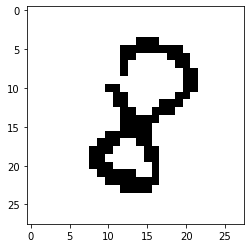

In [ ]:
digit = 32000
plt.imshow(X_train[digit].reshape(28,28), cmap = matplotlib.cm.binary)

In [ ]:
model = RBM(n_visible=784, n_hidden=500, n_epochs=15, eta=0.1, batch_size=20, random_state=42 )

In [ ]:
model.fit(X_test)

[========================================================================] 100%
[                                                                        ] N/A%

epoch: 0 free energy: -263.53882 reconstruction mse: 0.06558163265306123


[                                                                        ] N/A%

epoch: 1 free energy: -297.25766 reconstruction mse: 0.056192984693877554


[                                                                        ] N/A%

epoch: 2 free energy: -334.29376 reconstruction mse: 0.04992295918367347


[                                                                        ] N/A%

epoch: 3 free energy: -362.62128 reconstruction mse: 0.04649757653061225


[                                                                        ] N/A%

epoch: 4 free energy: -382.8683 reconstruction mse: 0.04335535714285714


[                                                                        ] N/A%

epoch: 5 free energy: -394.49234 reconstruction mse: 0.04159413265306122


[                                                                        ] N/A%

epoch: 6 free energy: -409.09885 reconstruction mse: 0.03972933673469388


[                                                                        ] N/A%

epoch: 7 free energy: -419.9312 reconstruction mse: 0.03839030612244898


[                                                                        ] N/A%

epoch: 8 free energy: -426.72614 reconstruction mse: 0.03694094387755102


[                                                                        ] N/A%

epoch: 9 free energy: -430.4405 reconstruction mse: 0.036263137755102044


[                                                                        ] N/A%

epoch: 10 free energy: -443.072 reconstruction mse: 0.035121428571428574


[                                                                        ] N/A%

epoch: 11 free energy: -448.173 reconstruction mse: 0.03426339285714286


[                                                                        ] N/A%

epoch: 12 free energy: -460.67816 reconstruction mse: 0.033251020408163266


[                                                                        ] N/A%

epoch: 13 free energy: -458.23416 reconstruction mse: 0.03289885204081633


[========================================================================] 100%

epoch: 14 free energy: -468.54355 reconstruction mse: 0.03195905612244898


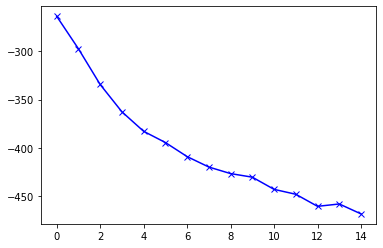

In [ ]:
plt.plot(range(model.n_epochs), model.eval_['free_energy'], 'bx-')

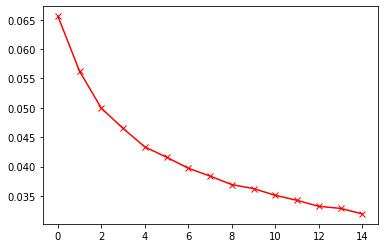

In [ ]:
plt.plot(range(model.n_epochs), model.eval_['reconstruct_mse'], 'rx-')

In [ ]:
h = model.v_to_h(X_train[0:101,:])
print(h.shape)
v_pred = model.h_to_v(h)
print(v_pred.shape)

(101, 500)
(101, 784)


In [ ]:
model.free_energy(X_train[0:2,:])

array([-435.1545 , -464.36432], dtype=float32)

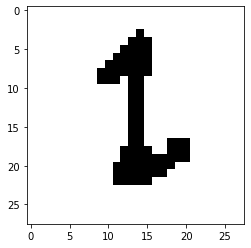

In [ ]:
plt.imshow(X_train[70].reshape(28,28), cmap = matplotlib.cm.binary)

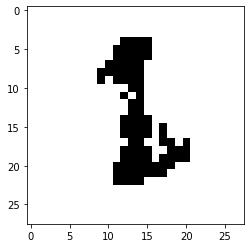

In [ ]:
plt.imshow(v_pred[70].reshape(28,28), cmap = matplotlib.cm.binary)

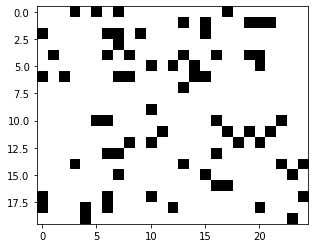

In [ ]:
plt.imshow(h[1].reshape(20,25), cmap = matplotlib.cm.binary)

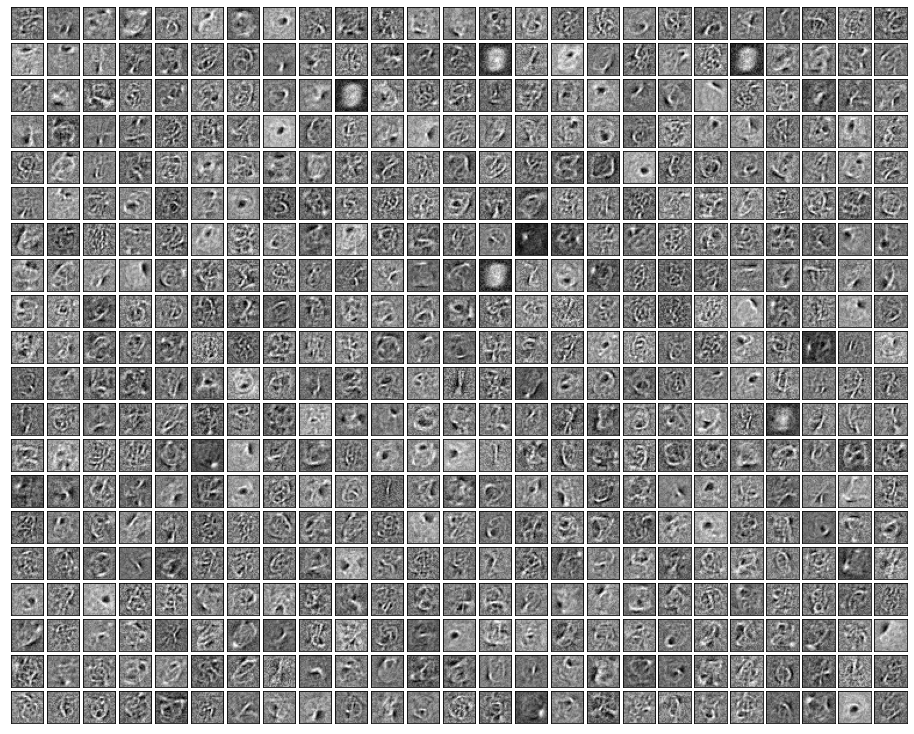

In [ ]:
# plot filter for each hidden unit

plt.figure(figsize=(12.5, 10))
for i in range(500):
    ax = plt.subplot(20, 25, i+1)
    plt.imshow(model.W[i].reshape(28,28), cmap = matplotlib.cm.binary)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout(pad=0.0)
plt.show()

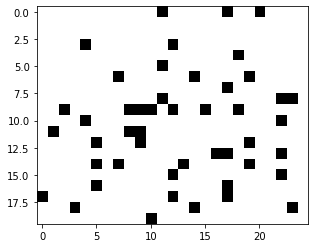

In [ ]:
h_random = np.random.binomial(n=1, p=0.1, size=(1,500))
plt.imshow(h_random.reshape(20,25), cmap = matplotlib.cm.binary)

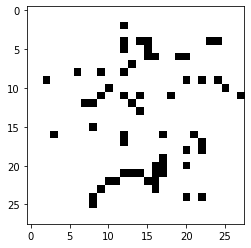

In [ ]:
v_random = model.h_to_v(h_random)
plt.imshow(v_random.reshape(28,28), cmap = matplotlib.cm.binary)

In [ ]:
model.h_to_v(h)

array([0, 1])

In [ ]:
model.gibbs_hvh(h)

[array([0, 0]), array([1, 1, 0])]

In [ ]:
model.gibbs_vhv(v)

[array([1, 1, 0]), array([1, 1])]